# Lab 1: "Quantization and Entropy Coding"

- Student full name: Javier Echávarri Trillo
- Student email: javier.echavarri01@estudiant.upf.edu


# 0. Introduction

During this lab, you will work with the concepts seen during the Lectures. The lab is divided into excercises related to the following fundamental concepts:

- Uniform quantization, and quantization error
- Entropy
- Huffman Coding / Decoding

The delivery will consist of a copy of this notebook, with your code, figures, and answers. Please, once finished, run all cells (hopefully without errors) and download your notebook as a `.ipynb` file, which will be submitted to Aula Global.

We recommend to work directly on a Google Colab notebook, since we do not require a powerful server, and everything is already set up. In any case, you can work in your own laptop if you prefer to, by installing all required dependencies.


In [34]:
# Install a few dependencies that are not included by default
!apt-get install -y ffmpeg
!ffmpeg -y -i https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav -af "volume=9dB" -t 20 -ac 1 -ar 11025 -acodec pcm_s16le speech.wav
!pip install huffman
!pip install bitarray

zsh:1: command not found: apt-get
ffmpeg version N-110491-g2919027936 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/HEAD-2919027 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-lib

In [35]:
# Check we are using python 3
import sys

assert sys.version_info.major == 3

In [36]:
# Some useful functions that will be used along the assignment

import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio


def generate_decay_signal(sample_rate=11025, freq=1000, phase=0, duration=20):
    """Generate a tone modulated by a decay signal

    This signal is useful to study the impact of quantization, since it uses
    the full dynamic range.

    Args:
        sample_rate (int): Sample rate
        freq (float): Tone frequency
        phase (float): Tone phase
        duration (float): Signal duration in seconds

    Returns:
        (np.array) Samples array
    """
    times = np.arange(0, duration, 1 / sample_rate)
    cy = np.cos(2 * np.pi * times * freq + phase)
    sy = np.sin(2 * np.pi * times * freq + phase)
    pulse = cy + sy
    unclipped_decay_signal = pulse * 25 * np.exp(-times * 0.5)
    decay_signal = np.minimum(np.maximum(unclipped_decay_signal, -1), 1)
    return decay_signal


def display_spectrogram(x, hop_length=128, n_fft=256, sample_rate=11025):
    """Display spectrogram of signal x

    Args:
        x (numpy.array): Array of samples
        hop_length (int): Spectrogram hop length
        n_fft (int): Spectrogram fft size
        sample_rate (int): Sample rate
    """
    from librosa.display import specshow

    data = librosa.amplitude_to_db(
        np.abs(librosa.core.stft(x, hop_length=hop_length, n_fft=n_fft, center=True)),
        ref=np.max,
    )
    plt.figure(figsize=(10, 5))
    specshow(
        data,
        x_axis="time",
        y_axis="linear",
        cmap="inferno",
        sr=sample_rate,
        hop_length=hop_length,
    )
    plt.colorbar(format="%+2.0f dB")


def display_audio_player(x, sample_rate=11025):
    """Display an embedded audio player

    Args:
        x (numpy.array): Array of samples
        sample_rate (int): Sample rate
    """
    return Audio(x, rate=sample_rate)

# 1. Quantization (40%)


## Exercise 1.1 (10%)

**a) Write a function to plot the waveform of an audio signal (add documentation as in `display_spectrogram`, use `matplotlib`, add at least axis names, make it nice)**


In [37]:
def display_waveform(signal, sample_rate=11025):
    """Plot the waveform of an audio signal

    Args:
        signal (numpy.array): Array of samples
        sample_rate (int): Sample rate
    """
    time_axis = np.arange(len(signal)) / sample_rate
    plt.plot(time_axis, signal)
    plt.xlabel("s")
    plt.ylabel("amplitude")
    plt.show()

**b) Plot the waveform of the signal generated with `generate_decay_signal()`**


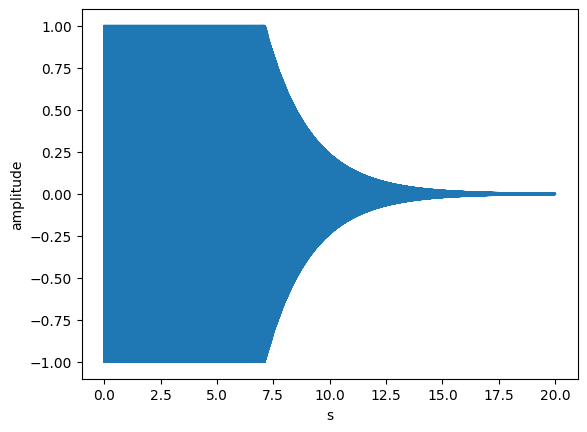

In [38]:
signal = generate_decay_signal()
display_waveform(signal)

**c) Embed an audio player in order to listen to the signal**


In [39]:
# embed audio player
display_audio_player(signal)

**d) Display the spectrogram using `display_spectrogram` function**


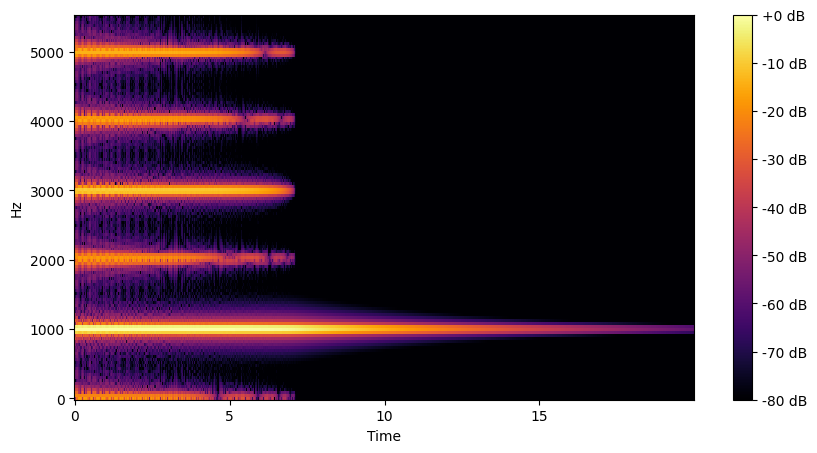

In [40]:
display_spectrogram(signal)

**e) Observe the waveform, the spectrogram, and listen to the audio. Describe briefly your observations**


(Answer here)
The Audio signal is a decay signal, which means that the amplitude of the signal decreases over time. The dominant frequency is 1000Hz and since the rest are all frequencies multiple to this one we can infer that they are harmonics and 1000 Haz is the fundamental frequency. From the plot we can say that it is a signal decay and we can see the amplitude decreasing, the audio also confirms this.


## Exercise 1.2 (25%)

Before describing the task, we present an explanation that might help to better understand the approach of the exercise.

### About symmetrical mid-rise vs. asymmetrical mid-tread

In the bibliography suggested:

_Introduction to Digital Audio Coding and Standards. Authors: Bosi, Marina and Goldberg, Richard E._
http://last.hit.bme.hu/download/vidtechlab/fcc/literature/audio/audio_coding_standards_book.pdf

The following claim is made:

_We typically choose quantizers that are symmetric in that there are an equal number of levels (codes) for positive and negative numbers._

However, in the case of standard PCM audio codings, this is not the case. For instance, 16 bits PCM WAV coding (16 bits signed integers) assigns `-32768` to $-1.0$ amplitude value, `0` to $0.0$ amplitude value, and `+32767` to $+1.0 - \frac{1}{2^{15}}$ amplitude value. The amplitude value $1.0$ has no representation in 16 bits PCM WAV audio files.


In [41]:
# Some code to illustrate the previous explanation.

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
from scipy.io.wavfile import write
from scipy.io.wavfile import read

x = np.array([-32768, -1, 0, 1, 32767], dtype=np.int16)
write("codec__pcm_s16le.wav", 8000, x)
sr, y = read("codec__pcm_s16le.wav")

In [42]:
!ffprobe  -v error -i codec__pcm_s16le.wav -show_entries stream=codec_name

[STREAM]
codec_name=pcm_s16le
[/STREAM]


In [43]:
# Convert to float 32 bits codec
!ffmpeg -y -v error -i codec__pcm_s16le.wav -acodec pcm_f32le codec__pcm_f32le.wav

In [44]:
sr, z = read("codec__pcm_f32le.wav")
for sample in z:
    print(sample)

-1.0
-3.0517578e-05
0.0
3.0517578e-05
0.9999695


---

**a) The following function "simulates" the quantization of a signal using an asymmetric uniform mid-tread quantizer with N bits. Please, explain how the function works, and why each line is needed. Imagine you select N=2: does it mean this python program is using 2 bits to store internally each of the numbers produced by this `quantize(x, N)` python function? (you can check it with https://numpy.org/doc/stable/reference/generated/numpy.ndarray.nbytes.html). Why do we say this function "simulates" the quantization process?**

```python
def quantize(x, N):
    """ Quantize signal using N bits
    Args:
        x (numpy.array): Array of samples
        N (int): Number of bits
    """
    x = np.array(x)
    quantized = np.round(x * 2**(N-1))
    quantized = np.minimum(quantized, 2**(N-1) - 1)
    quantized = np.maximum(quantized, -2**(N - 1))
    quantized = quantized.astype(np.int16)
    return quantized.reshape(x.shape)
```

**Remember this mid-tread quantization function:**

![](https://vru.vibrationresearch.com/wp-content/uploads/2019/10/quantization_midtread_8bit.png-1.png)


1. code explanantion as comments in the code
2. if N = 2 the function stores the numbers in 2 bytes, which is 16 bits.
3. we say it simulates because it is not a real quantization, the function just simulates the quantization process.


In [45]:
def quantize(x, N):
    """Quantize signal x using N bits
    Args:
        x (numpy.array): Array of samples
        N (int): Number of bits
    """
    # we convert the array to numpy array
    x = np.array(x)
    # we round the array to the nearest integer
    quantized = np.round(x * 2 ** (N - 1))
    # we clip the array to the range of the quantization
    quantized = np.minimum(quantized, 2 ** (N - 1) - 1)
    quantized = np.maximum(quantized, -(2 ** (N - 1)))
    # we convert the array to int16
    quantized = quantized.astype(np.int16)
    # we return the array
    return quantized.reshape(x.shape)

**A set of tests are provided to check if your function is correctly implemented or not:**


x: -1.5, code: -4, dequant: -1.0, expected code: -4, expected dequant: -1.0
x: -1.0, code: -4, dequant: -1.0, expected code: -4, expected dequant: -1.0
x: -0.88, code: -4, dequant: -1.0, expected code: -4, expected dequant: -1.0
x: -0.86, code: -3, dequant: -0.75, expected code: -3, expected dequant: -0.75
x: -0.126, code: -1, dequant: -0.25, expected code: -1, expected dequant: -0.25
x: -0.125, code: 0, dequant: 0.0, expected code: 0, expected dequant: 0.0
x: 0, code: 0, dequant: 0.0, expected code: 0, expected dequant: 0.0
x: 0.125, code: 0, dequant: 0.0, expected code: 0, expected dequant: 0.0
x: 0.126, code: 1, dequant: 0.25, expected code: 1, expected dequant: 0.25
x: 1.0, code: 3, dequant: 0.75, expected code: 3, expected dequant: 0.75
x: 1.5, code: 3, dequant: 0.75, expected code: 3, expected dequant: 0.75


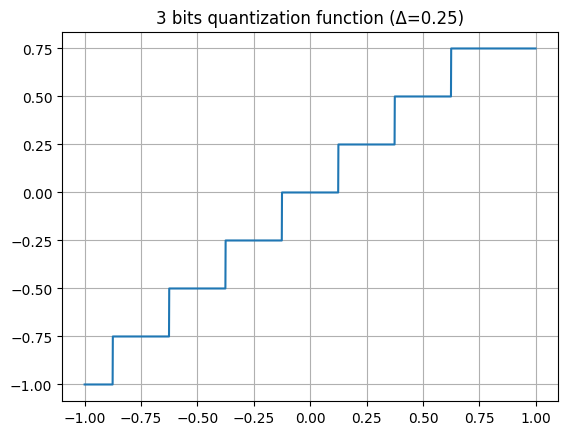

In [46]:
# Run this cell for automatic testing


def dequantize(codes, N):
    """Dequantize signal using N bits

    Args:
        x (numpy.array): Array of samples
        N (int): Number of bits
    """
    return np.array(codes) / 2 ** (N - 1)


# Test
test_vector = [-1.5, -1.0, -0.88, -0.86, -0.126, -0.125, 0, 0.125, 0.126, 1.0, 1.5]
expected_codes = [-4, -4, -4, -3, -1, 0, 0, 0, 1, 3, 3]
expected_dequantized = [-1.0, -1.0, -1.0, -0.75, -0.25, 0.0, 0.0, 0.0, 0.25, 0.75, 0.75]
codes = quantize(test_vector, 3)
dequantized = dequantize(codes, 3)

for x, y, z, e_y, e_z in zip(
    test_vector, codes, dequantized, expected_codes, expected_dequantized
):
    print(
        "x: {0}, code: {1}, dequant: {2}, expected code: {3}, expected dequant: {4}".format(
            x, y, z, e_y, e_z
        )
    )
    assert y == e_y
    assert z == e_z

# Quantization function using 3 bits
plt.figure()
x = np.arange(-1.0, 1.0, 0.001)
y = dequantize(quantize(x, 3), 3)
plt.plot(x, y)
plt.grid()
plt.title("3 bits quantization function (Δ=0.25)")
plt.show()

**b) Complete the function `get_snr(N)` to compute the SNR in dBs given a number of bits for a signal with uniform distribution.**

**Note that we added a hack (adding or subtracting $\frac{1}{2^N}$) in order to use a mid-rise quantizer because the formula $SNR = N \times 6.021$ is valid for a symmetric quantizer with $2^N$ steps.**

Here, please remember that the SNR in dBs is given by:

snr = 10 \* np.log10(energy_x / energy_qn)

Where energy_x is the energy of signal x, and energy_qn is the energy of the quantization error (i.e. x-y).

Do not forget to return the snr at the end of the function.


In [47]:
def get_snr_uniform(N):
    x = np.random.uniform(low=-1.0, high=1.0, size=(1000000,))
    y = dequantize(quantize(x - (1 / 2**N), N), N) + 1 / 2**N  # for this experiment
    # we use a mid-rise quantizer
    # (symmetry reasons)
    # Complete this function:
    """
    Calculate the SNR of the quantization using the formula:
    Args:
        N (int): Number of bits
    """
    # energy of x and qn
    energy_x = np.var(x) * len(x)
    energy_qn = np.var(x - y) * len(x - y)

    snr = 10 * np.log10(energy_x / energy_qn)
    return snr


def get_theoretical_snr_uniform(N):
    theo_snr = N * 6.021
    return theo_snr


N_range = range(1, 16)
snrs = [get_snr_uniform(N) for N in N_range]
theo_snrs = [get_theoretical_snr_uniform(N) for N in N_range]
for N, snr, theo_snr in zip(N_range, snrs, theo_snrs):
    print(
        "N:{0} bits - SNR:{1:.2f}dB - Theoretical SNR:{2:.2f}dB".format(
            N, snr, theo_snr
        )
    )

N:1 bits - SNR:6.02dB - Theoretical SNR:6.02dB
N:2 bits - SNR:12.04dB - Theoretical SNR:12.04dB
N:3 bits - SNR:18.05dB - Theoretical SNR:18.06dB
N:4 bits - SNR:24.08dB - Theoretical SNR:24.08dB
N:5 bits - SNR:30.11dB - Theoretical SNR:30.11dB
N:6 bits - SNR:36.12dB - Theoretical SNR:36.13dB
N:7 bits - SNR:42.14dB - Theoretical SNR:42.15dB
N:8 bits - SNR:48.16dB - Theoretical SNR:48.17dB
N:9 bits - SNR:54.19dB - Theoretical SNR:54.19dB
N:10 bits - SNR:60.21dB - Theoretical SNR:60.21dB
N:11 bits - SNR:66.23dB - Theoretical SNR:66.23dB
N:12 bits - SNR:72.25dB - Theoretical SNR:72.25dB
N:13 bits - SNR:78.27dB - Theoretical SNR:78.27dB
N:14 bits - SNR:84.28dB - Theoretical SNR:84.29dB
N:15 bits - SNR:90.30dB - Theoretical SNR:90.31dB


## Exercise 1.3 (5%)

**a) Create a decay signal using `generate_decay_signal()` and apply a quantization + dequantization process to the previous signal using 4 bits. Then display the waveform, the spectrogram, and an audio player of the resulting signal.**

Tip: In order to display the waveform, spectrogram, or audio player, the signal must be in standard range (float from -1.0 to 1.0). That is why, we suggest to first apply a quantization (in order to convert from a float range to N discrete steps), and then a dequantization (for going back from N discrete steps to a float range between -1.0 and 1.0).


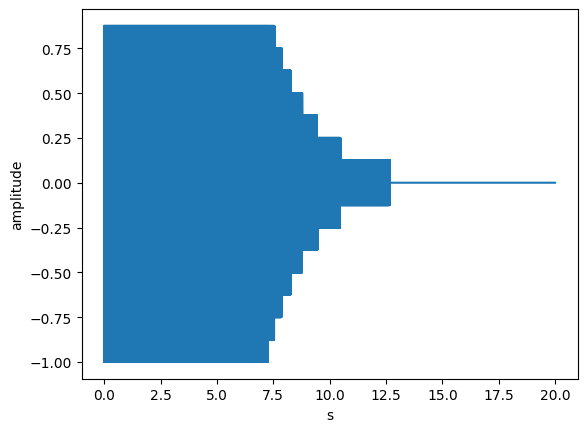

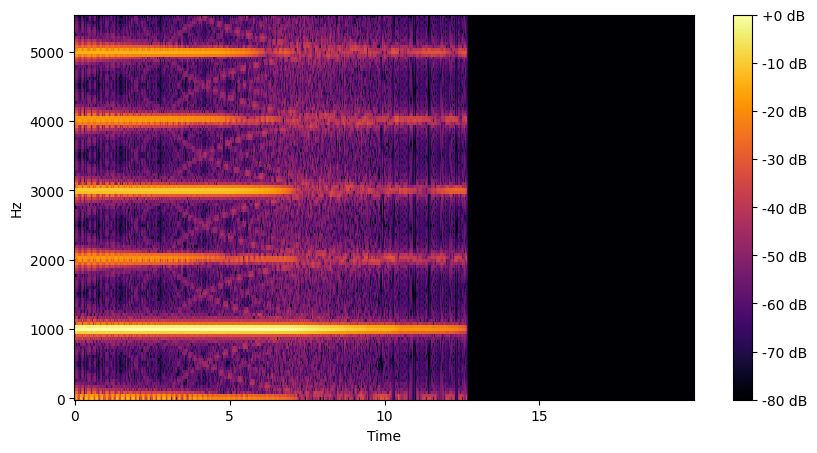

In [48]:
signal = generate_decay_signal()
signal = quantize(signal, 4)
signal = dequantize(signal, 4)

display_waveform(signal)
display_spectrogram(signal)
display_audio_player(signal)

**b) Apply a quantization + dequantization process to the previous signal using 8 bits, and display the waveform, the spectrogram, and an audio player of the resulting signal.**


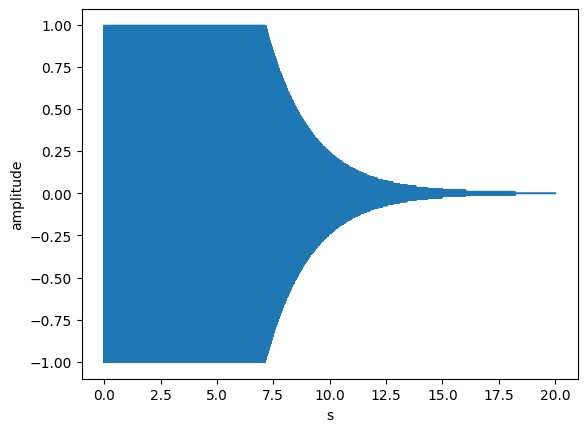

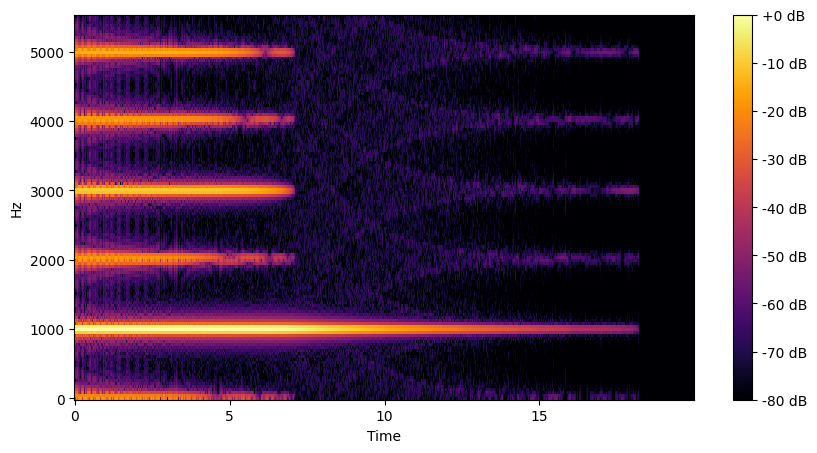

In [49]:
signal = generate_decay_signal()
signal = quantize(signal, 8)
signal = dequantize(signal, 8)

display_waveform(signal)
display_spectrogram(signal)
display_audio_player(signal)

**c) Include any observation you might find interesting about this analysis**


Since the resolution has decreased we see that for N=4 the audio is unhearable earlier, this is due to the adjustment and it is more clear when we add the plots for N=8.


# 2. Entropy calculation (20%)


## Exercise 2.1 (20%)

**a) Develop a function that allows you to plot the entropy of a source with variable output probabilities. We wish to observe that the maximum source entropy does indeed occur when the source outputs are equally likely.**

**The head of the function should be:**

```python
def calculate_entropy(probs):
    """
        Args:
            probs (np.array): Array of probs. for each symbol in the source
        Returns:
            (float) H (i.e. Entropy)
    """
```

**Please, take into account the cases where probabilities are 0.0, or incorrect inputs with negative probabilities (we can return `np.nan` in that case)**

First assert is the most important one:

```python
assert(calculate_entropy([0.5, 0.5]) == 1.0)
```

Complying with the rest of asserts is a bit harder:

```python
assert(calculate_entropy([1.0, 0.0]) == 0.0)
assert(np.isnan(calculate_entropy([-1.0, 0.0])))
assert(calculate_entropy([0.0, 1.0]) == 0.0)
```

So I consider the three last ones as optional (they just consider edge cases or incorrect inputs).


In [50]:
def calculate_entropy(probs):
    """
    Args:
        probs (np.array): Array of probs. for each symbol in the source
    Returns:
        (float) H (i.e Entropy)
    """

    # probs cant be negative
    # probs = 0 give errors
    for prob in probs:
        if prob == 0:
            return 0
        if prob < 0:
            return np.nan

    # sum of probs cant be greater than 1
    if np.sum(probs) > 1:
        return np.nan

    # Basix Structure of code
    H = -np.sum(probs * np.log2(probs))
    return H

In [51]:
assert calculate_entropy([0.5, 0.5]) == 1.0
assert calculate_entropy([1.0, 0.0]) == 0.0
assert np.isnan(calculate_entropy([-1.0, 0.0]))
assert calculate_entropy([0.0, 1.0]) == 0.0

**b) Consider a simple two-output source $[m_1, m_2]$ with respective probabilities $[a, 1 - a]$, and plot the entropy as a function of the parameter $a$, where $0 ≤ a ≤ 1$.**


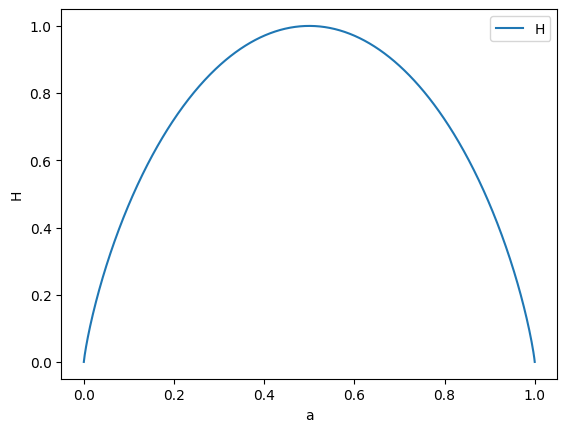

In [52]:
a_values = np.linspace(0, 1, 1000)
entropies = [calculate_entropy([a, 1 - a]) for a in a_values]
plt.plot(a_values, entropies, label="H")
plt.xlabel("a")
plt.ylabel("H")
plt.legend()
plt.show()

**c) Optional: consider more complex cases such as a three output source $[m_1, m_2, m_3]$ with
respective probabilities $[a, b, 1 − a − b]$. Plot a 2D image with `plt.imshow` where entropy is displayed as a function of `a` and `b` parameters.**


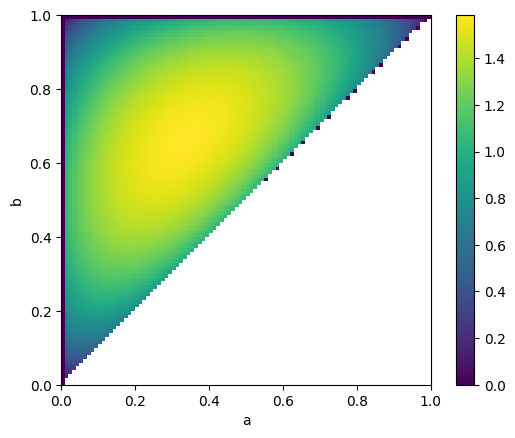

In [53]:
a_values = np.linspace(0, 1, 100)
b_values = np.linspace(0, 1, 100)
entropies = np.zeros((len(a_values), len(b_values)))
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        entropies[i, j] = calculate_entropy([a, b, 1 - a - b])
plt.imshow(entropies, extent=[0, 1, 0, 1])
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar()
plt.show()

# 3. Huffman Encoding (40%)

In this exercise, Huffman coding will be applied to compress `speech.wav` file.


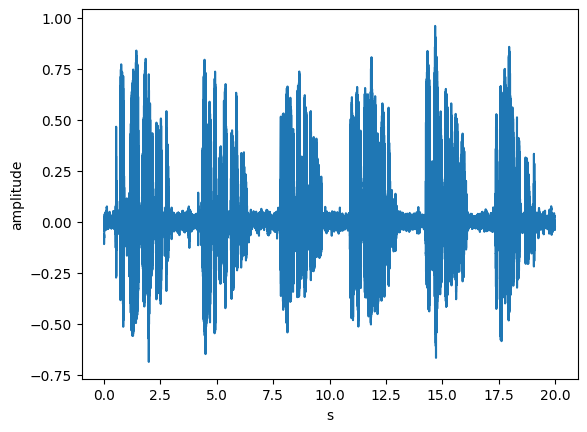

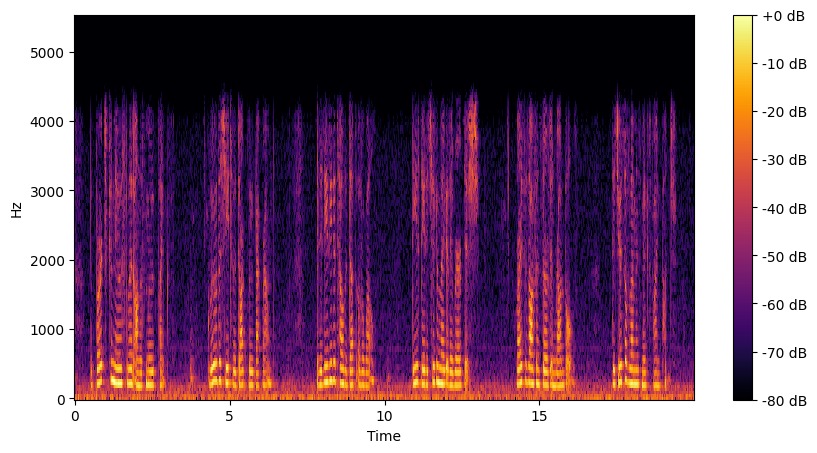

In [54]:
x, sr = librosa.load("speech.wav", sr=11025, mono=True)
display_waveform(x)
display_spectrogram(x)
display_audio_player(x)

## Exercise 3.1 (15%)


**a) Quantize signal `x` using 4 bits. Call it `y`**

Tip: The answer is:

```
bits_per_sample = 4
y = quantize(x, bits_per_sample)
```

Please, do not spend time dealing with it.


In [62]:
bits_per_sample = 4
y = quantize(x, bits_per_sample)

[-1 -1 -1 ...  0  0  0]


**b) Implement a function that computes the probability of occurrence per symbol for `y`.**

**The header of the function must be:**

Tip: With `np.unique(y, return_counts=True)`, the answer can be done with three lines. Beware that np.unique returns counts, instead of probabilities, so you have to normalize them (probabilities sum 1.0).

Remember that a function can return more than one element in python, e.g.

```python
def get_prob_per_symbol(y):
    """ Get symbol occurrence probability
    Args:
        x (np.array): Input signal
    Returns:
        (np.array, np.array): (sorted symbols, corresponding probabilities)
    """
    # Complete function here
    return symbols, probs
symbols, probs = get_prob_per_symbol(y)
```


In [64]:
def get_prob_per_symbol(y):
    """Get symbol ocurrence probability
    Args:
        y (np.array): Array of symbols
    Returns:
        (np.array, np.array): (sorted symbols, corresponding probs))
    """
    # total symbols
    total_symbols = len(y)
    # find unique symbols and their counts
    symbols, counts = np.unique(y, return_counts=True)
    # find probs
    probs = counts / total_symbols

    # sort symbols and probs
    sorted_idx = np.argsort(probs)[::-1]
    symbols = symbols[sorted_idx]
    probs = probs[sorted_idx]

    return symbols, probs

**c) Use the implemented function to display the symbol probability distribution for `y`**


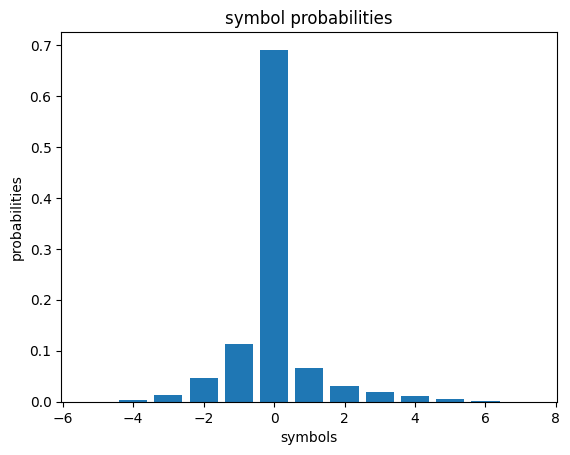

In [65]:
y_symbols, y_probs = get_prob_per_symbol(y)
plt.bar(y_symbols, y_probs)
plt.xlabel("symbols")
plt.ylabel("probabilities")
plt.title("symbol probabilities")
plt.show()

**d) Do you think this probability distribution will be similar in other speech signals?**


(Answer here)
I think it will because it is not random noise, it is a speech signal and the probability distribution will be similar in other speech signals.


**e) Compute the entropy of `y`**


In [67]:
y_entropy = calculate_entropy(y_probs)
print("Entropy of y: {0:.2f} bits/symbol".format(y_entropy))

Entropy of y: 1.69 bits/symbol


## Exercise 3.2 (15%)


**a) Review the documentation of `huffman` python package:**

https://pypi.org/project/huffman/

**and generate a codebook for the previously computed symbols and probabilities.**

Given a list of symbols, and a list of probabilities, (as returned by get_prob_per_symbol)
the input to huffman.codebook(symbol_probs) must be:

`symbol_probs = [(s, p) for (s, p) in zip(symbols, probs)]`

It is the format huffman package understands.


In [71]:
import huffman

symbols_probs = [(symbol, prob) for symbol, prob in zip(y_symbols, y_probs)]

codes = huffman.codebook(symbols_probs)
for symbol, code in codes.items():
    print("symbol: {0}, code: {1}".format(symbol, code))

symbol: 0, code: 1
symbol: -1, code: 011
symbol: 1, code: 001
symbol: -2, code: 0101
symbol: 2, code: 0001
symbol: 3, code: 01001
symbol: -3, code: 01000
symbol: 4, code: 00001
symbol: 5, code: 000001
symbol: -4, code: 0000001
symbol: 6, code: 00000001
symbol: -5, code: 000000001
symbol: 7, code: 000000000


**b) Consider the bit array `10010110001`: is the associated symbols sequence unique?**


(Answer here)
It is not, there are different ways to decode it.


**c) Compute:**

- **Code mean length**
- **Code efficiency**
- **Compression ratio**


In [89]:
mean_length = np.sum([len(code) * prob for symbol, prob in symbols_probs])
code_efficiency = (y_entropy / mean_length) * 100
compression_ratio = np.log2(len(y_symbols)) / mean_length

In [90]:
print("Mean length: {0}".format(mean_length))
print("Code efficiency: {0:.2f}%".format(100 * code_efficiency))
print("Compression ratio: {0:.2f}%".format(100 * compression_ratio))

Mean length: 9.000000000000002
Code efficiency: 1876.57%
Compression ratio: 41.12%


## Exercise 3.3 (10%)


**a) Using `bitarray` python package, encode the signal into a sequence of bits (method `.encode()` of `bitarray` package) with the codebook previously generated.**

https://pypi.org/project/bitarray/

Update:
The answer is:

```
from bitarray import bitarray
codebook_bitarray = {}
for (k, v) in codebook.items():  # codebook as returned by huffman package
  codebook_bitarray[k] = bitarray(v)
a = bitarray()
a.encode(codebook_bitarray, y)
print(a)
```

Instead of implementing it from scratch, please explain what it does.


In [86]:
from bitarray import bitarray

# empty bitrray -> stores huffman codes
codebook_bitarray = {}
# iterate codes
for k, v in codes.items():  # codebook as returned by huffman package
    # for each item in codebook, new entry in bitarray
    codebook_bitarray[k] = bitarray(v)

# new bitarray
a = bitarray()
# compress y and store in a
a.encode(codebook_bitarray, y)
print(a)

bitarray('011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011110110110110110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

**b) Decode the signal using `.decode()` method of `bitarray` package, and verify it equals `y` for all samples.**


In [88]:
decoded_y = np.array(a.decode(codebook_bitarray), dtype=np.int16)
print(decoded_y)
assert np.all(y == decoded_y)

[-1 -1 -1 ...  0  0  0]


**c) Compute the size in kilobits per second of the bit arrays before (i.e. fix-length) and after Huffman encoding.**


In [100]:
print("kbps fixed-length: {0}kbps".format(kbps_per_second_fixlength))
print("kbps Huffman: {0}kbps".format(kbps_per_second_encoded))

kbps fixed-length: 0.004kbps
kbps Huffman: 0.0kbps


**d) Are the previous kbps values consistent with the compression ratio already computed before?**


(Answer here)
